In [1]:
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = yf.Ticker("^BVSP").history(start='2014-01-01', end='2024-01-01')
df = df.drop(columns=['Dividends', 'Stock Splits'], axis=1)
print(df.head(5))

                              Open     High      Low    Close   Volume
Date                                                                  
2014-01-02 00:00:00-02:00  51522.0  51656.0  50246.0  50341.0  3476300
2014-01-03 00:00:00-02:00  50348.0  50981.0  50269.0  50981.0  7360400
2014-01-06 00:00:00-02:00  50980.0  51002.0  50451.0  50974.0  3727800
2014-01-07 00:00:00-02:00  50982.0  51478.0  50429.0  50430.0  3339500
2014-01-08 00:00:00-02:00  50431.0  50793.0  50424.0  50577.0  2916500


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2476 entries, 2014-01-02 00:00:00-02:00 to 2023-12-28 00:00:00-03:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2476 non-null   float64
 1   High    2476 non-null   float64
 2   Low     2476 non-null   float64
 3   Close   2476 non-null   float64
 4   Volume  2476 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 116.1 KB
None


In [4]:
print(df.isna().sum())
print(df.eq(0).any())

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64
Open      False
High      False
Low       False
Close     False
Volume     True
dtype: bool


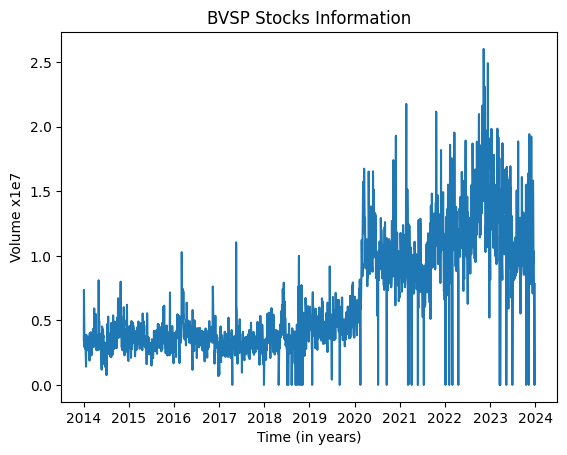

In [5]:
plt.plot(df.index, df['Volume'] / 1e7)
plt.title('BVSP Stocks Information')
plt.xlabel('Time (in years)')
plt.ylabel('Volume x1e7')
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

x = df.drop(columns=['Close'], axis=1).values
y = df['Close'].values

scaler = MinMaxScaler(feature_range=(0, 1))
x = scaler.fit_transform(x)
y = np.reshape(y, (-1, 1))
y = scaler.fit_transform(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print(x_train.shape)
print(x_test.shape)

(1733, 4, 1)
(743, 4, 1)


In [7]:
# type: ignore
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout

lstm = Sequential()
lstm.add(Input(shape=(x_train.shape[1], 1)))
lstm.add(LSTM(64))
lstm.add(Dense(32))
lstm.add(Dropout(0.5))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mse')
print(lstm.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
# type: ignore
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
history = lstm.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, callbacks=[es])

Epoch 1/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1042 - val_loss: 0.0036
Epoch 2/100
43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0162

d:\Python3\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: loss,val_loss
  current = self.get_monitor_value(logs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - val_loss: 0.0019
Epoch 3/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 9.9958e-04
Epoch 4/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 - val_loss: 9.2802e-04
Epoch 5/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096 - val_loss: 9.8979e-04
Epoch 6/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_loss: 0.0015
Epoch 7/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - val_loss: 7.0142e-04
Epoch 8/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 7.9644e-04
Epoch 9/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - val_loss: 0.0018
Epoch 10/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0080 - val_loss: 3.2258e-04
Epoch 11/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 4.9259e-04
Epoch 12/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073 - val_loss: 6.9205e-04
Epoch 13/100
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s

In [10]:
pred = lstm.predict(x_test)

mse = np.mean(((pred - y_test) ** 2))
print('Mean Square Error:', mse)
print("Root Mean Square Error:", np.sqrt(mse))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step
Mean Square Error: 0.00026148914058621737
Root Mean Square Error: 0.016170625856355016
